In [1]:
from keras.layers import Lambda, Input, Dense, Conv1D, MaxPool1D, UpSampling1D, Flatten, Reshape
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from scipy.stats import multivariate_normal as multi_norm

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/bluetoothDevicesByWeek.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
df['app'].unique().shape

(23275,)

In [4]:
# Clean app names
# for r in range(len(df.index)):
#     if df.iloc[r, 2].find(':') > -1:
#         print df.iloc[r]
#         df.iloc[r, 2] = 'Phone'

In [5]:
df.iloc[5699]

id                   6
date           2004.34
app     413791240838.0
freq                61
Name: 5699, dtype: object

In [6]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [7]:
data_dict, unique = convert_to_dict(df)

In [8]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [9]:
x_train_full, y_train = dict_to_np_array(data_dict)
print x_train_full.shape, y_train.shape

(1841, 23275) (1841,)


In [10]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

In [11]:
x_train_full.shape

(1841, 23275)

In [12]:
# x_train = x_train_full.copy()
# for i in np.where(x_train_full.sum(axis=0) > 1)[0][::-1]:
# x_train = np.delete(x_train_full, np.where(x_train_full.sum(axis=0) == 1)[0], axis=1)
x_train = x_train_full[:, x_train_full.sum(axis=0).argsort()[::-1][:72*78]].reshape((-1, 72*78, 1))

In [13]:
print x_train.shape

(1841, 5616, 1)


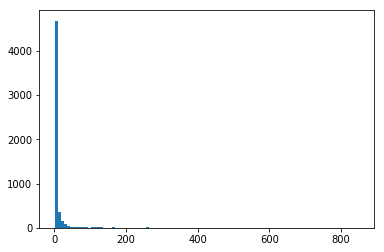

In [14]:
plt.hist(x_train.sum(axis=0), bins=100)
plt.show()

# n = 10  # how many digits we will display
# choice = np.random.choice(range(len(x_train)), n, replace=False)
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     # display original
#     ax = plt.subplot(1, n, i + 1)
#     plt.imshow(x_train[choice[i], :200])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

### Train VAE

In [14]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    print batch, dim
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    print epsilon
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = x_train.shape[-2:]

# network parameters
input_shape = original_dim
# intermediate_dim = 1000
# inter_dim_2 = 250
latent_dim = 32
filters = 32
kernel_size = (3,)

batch_size = 128
# epochs = 50

In [16]:
input_shape

(5616, 1)

In [17]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    x = Conv1D(filters=filters, kernel_size=kernel_size,
               activation='relu', strides=2, padding='same')(x)
    x = MaxPool1D((2,), padding='same')(x)
    filters *= 2
    
# shape info needed to build decoder model
shape = K.int_shape(x)
    
x = Flatten()(x)
x = Dense(2*latent_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Tensor("z/strided_slice:0", shape=(), dtype=int32) 32
Tensor("z/random_normal:0", shape=(?, 32), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5616, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2808, 32)     128         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1404, 32)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 702, 64)      6208        max_pooling1d_1[0][0]          

In [18]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2]))(x)

for i in range(3):
    x = UpSampling1D(2)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', padding='same')(x)
    filters //= 2

x = UpSampling1D(2)(x)
outputs = Conv1D(filters=1, kernel_size=kernel_size,
                activation='sigmoid', padding='same', 
                 name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22464)             741312    
_________________________________________________________________
reshape_1 (Reshape)          (None, 351, 64)           0         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 702, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 702, 128)          24704     
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 1404, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1404, 64)          24640     
__________

In [19]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Tensor("encoder/z/strided_slice:0", shape=(), dtype=int32) 32
Tensor("encoder/z/random_normal:0", shape=(?, 32), dtype=float32)


In [21]:
reconstruction_loss = categorical_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim[0]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.01, decay=1.0e-4))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 5616, 1)           0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  1448256   
_________________________________________________________________
decoder (Model)              (None, 5616, 1)           796929    
Total params: 2,245,185
Trainable params: 2,245,185
Non-trainable params: 0
_________________________________________________________________


In [22]:
vae.fit(x_train, epochs=1000, batch_size=batch_size)

Epoch 1/1000


InvalidArgumentError: Incompatible shapes: [128,5616] vs. [128]
	 [[Node: training/Adam/gradients/add_1_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@training/Adam/gradients/add_1_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training/Adam/gradients/add_1_grad/Shape, training/Adam/gradients/add_1_grad/Shape_1)]]

In [22]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

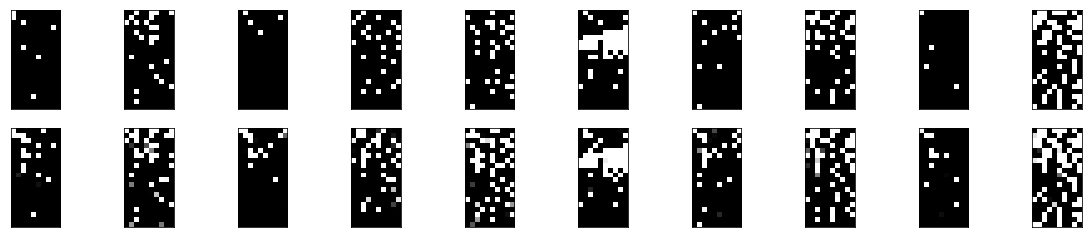

In [23]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

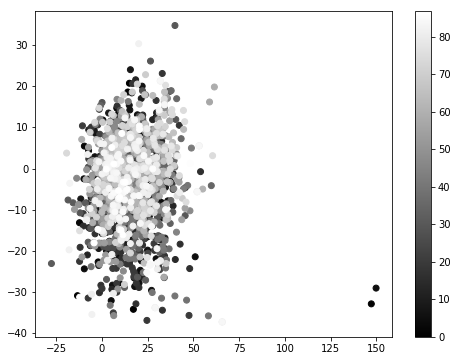

In [24]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [25]:
# pair_dist = []
# pair_label = []
# pair_score =[]

# for i in np.arange(x_test_encoded[2].shape[0]):
#     for j in range(i + 1, x_test_encoded[2].shape[0]):
#         d = np.sqrt(np.power(x_test_encoded[2, i] - x_test_encoded[2, j], 2).sum())
#         pair_dist.append(d)
#         pair_score.append(1 / (d + 1.0e-5))
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)

# print roc_auc_score(y_true=pair_label, y_score=pair_score)

In [26]:
# pair_dist = np.array(pair_dist)
# pair_label = np.array(pair_label)

# bins = np.linspace(pair_dist.min(), pair_dist.max(), 100)

# plt.hist(pair_dist[pair_label], bins, alpha=0.5, label='pos')
# plt.hist(pair_dist[pair_label == False], bins, alpha=0.5, label='neg')
# plt.legend(loc='upper right')
# plt.show()

In [27]:
# pair_dist = []
# pair_label = []

# for i in np.arange(x_train.shape[0]):
#     for j in range(i, x_train.shape[0]):
#         d = np.sqrt(np.power(x_train[i] - x_train[j], 2).sum())
#         pair_dist.append(d)
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)
    
# print roc_auc_score(y_true=pair_label, y_score=pair_dist)

In [28]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[ 14.614131    -3.451315    -1.054156    -3.77469      1.7571453
   1.6144184   -1.2198431   -0.6559473    1.196429     9.737632
   4.9783363   -1.6362103   -1.7546933   -0.8162566   -0.75092596
  -0.13828254   1.4389863   -0.30896485  -3.8808782   28.635338
  -2.2553146    2.2444205   -3.7421691  -11.4277935    0.67408013
   2.0147088   -3.9587364   -1.496527    -2.904797     0.6025982
  -3.6351864    2.617541  ]
[13.23395   10.15909    9.118197   9.560115  11.086982   8.661651
 11.588699  10.019711   8.787927  14.343926  12.250062   9.896418
  9.465989   9.982763   9.351093  10.659166  10.972062  11.210817
 11.235339  20.203728   9.8605995 10.12376   10.934647  12.866853
  9.78127    9.668673  10.916065   9.334157  10.73078    9.639947
  9.240886   8.741958 ]


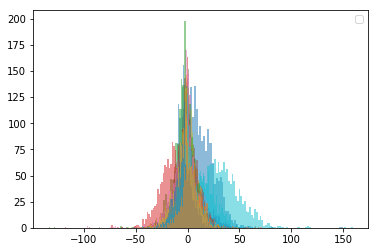

In [29]:
for i in range(len(std)):
    plt.hist(x_test_encoded[0, :, i], bins=100, alpha=0.5)

# plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
# plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

In [36]:
x_test_encoded[0].shape

(1911, 32)

In [37]:
cov = np.cov(x_test_encoded[0].transpose())
print cov

[[ 1.83991918  0.10838809  0.0404853  ... -0.4582909   0.50363063
  -0.77448507]
 [ 0.10838809  0.89240863 -0.50724623 ... -0.53851793 -0.17500165
  -0.08638175]
 [ 0.0404853  -0.50724623  0.81665407 ...  0.22555581 -0.15694436
   0.39498853]
 ...
 [-0.4582909  -0.53851793  0.22555581 ...  1.01211671 -0.03154525
   0.24474293]
 [ 0.50363063 -0.17500165 -0.15694436 ... -0.03154525  1.99297641
  -0.57082593]
 [-0.77448507 -0.08638175  0.39498853 ...  0.24474293 -0.57082593
   1.27489183]]


In [38]:
cov.shape

(32, 32)

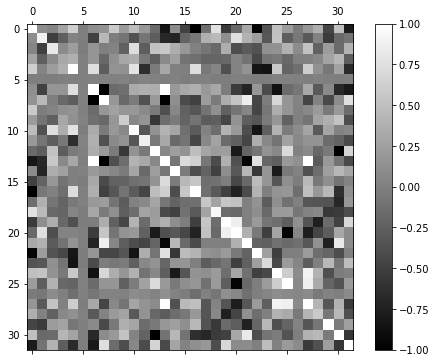

In [96]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cov, vmin=-1, vmax=1)
fig.colorbar(cax)
# ticks = np.arange(0,32,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

### Apply Generative Probabilistic Model

In [43]:
N_SINGLETONS = 65
N_PAIRS = 5

In [44]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [45]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[39 77 55 73 33 80 53 28 64 35 38 48 46 62 74 36 10 41 57 52 65 17  0 15
 18  8 49 50 24 22 45 75 12 21 78 30 63 61 40 81 13 42 76 47 16 19 60 71
 87 70  1  9 67 83 66 32 68 85  5 54  3 37 84 20 72]


In [46]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[2, 4, 6, 7, 11, 14, 23, 25, 26, 27, 29, 31, 34, 43, 44, 51, 56, 58, 59, 69, 79, 82, 86]


In [47]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[51 59  7 27 44]


In [48]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
#     print pid
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
#     print w1, w2
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1)
    vec_list.append(app_vec2)
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
#     print pid
#     print w
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)

In [49]:
vec_list = np.array(vec_list)

In [50]:
test_encoded_imgs = encoder.predict(vec_list)
test_decoded_imgs = decoder.predict(test_encoded_imgs[2])

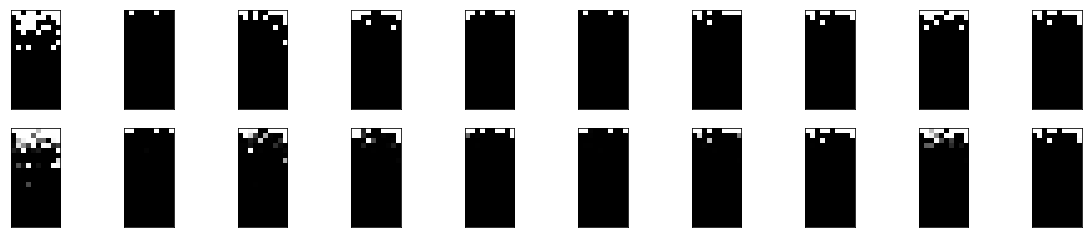

In [51]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(vec_list[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [52]:
points = encoder.predict(np.array(vec_list))[2]

In [82]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(points)

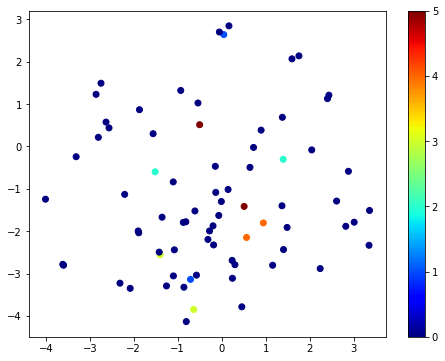

In [83]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [122]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
std_axis = np.std(points, axis=0)
print std_axis
print sigma

[-0.23759198 -0.602541   -0.7946218   0.03827273 -0.03928642 -0.09849337
  0.40824294  0.7814076   0.25968134  0.4960207  -0.67223287  1.4895954
  0.7519832   0.01561654  1.1306896  -0.9486553  -0.29654372  0.46457154
 -1.1475381  -0.46248454 -0.2839781   0.5077993  -0.89653    -0.7757096
  0.54863465  0.64669615 -0.1670635  -0.57344645  0.6931591  -0.5355042
 -0.05315622 -0.04518405]
[1.4998274  1.0140774  0.9160047  1.0285399  1.610918   1.0860342
 1.6992648  1.2572731  1.1205882  0.72844803 1.2471511  1.005415
 1.0271875  1.8344139  1.0762831  0.7090244  1.5439787  0.8576847
 1.0488368  1.2067201  1.3205566  1.1511307  1.3687989  0.8915071
 1.4892838  0.9764743  1.0285589  1.4421742  0.94243836 1.0367337
 1.4879575  1.0563554 ]
1.3676807


In [124]:
nu = 0.1

In [125]:
t = (np.ones(std_axis.shape) * nu) / std_axis
# dis_var = np.matmul(t.transpose(), cov)

In [126]:
dis_var = np.diag(t)
print dis_var

[[0.06667434 0.         0.         ... 0.         0.         0.        ]
 [0.         0.0986118  0.         ... 0.         0.         0.        ]
 [0.         0.         0.10916974 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.09645678 0.         0.        ]
 [0.         0.         0.         ... 0.         0.06720622 0.        ]
 [0.         0.         0.         ... 0.         0.         0.09466511]]


In [128]:
cov = np.cov(points.transpose())

In [129]:
cov

array([[ 2.27988052,  0.14650851,  0.20527899, ..., -0.68239207,
         0.77343707, -0.80048859],
       [ 0.14650851,  1.04225006, -0.56325659, ..., -0.59763585,
        -0.20985815,  0.07191377],
       [ 0.20527899, -0.56325659,  0.85040325, ...,  0.21670423,
        -0.04528916,  0.12538596],
       ...,
       [-0.68239207, -0.59763585,  0.21670423, ...,  1.08934145,
        -0.16530628,  0.34398435],
       [ 0.77343707, -0.20985815, -0.04528916, ..., -0.16530628,
         2.24393692, -0.58146036],
       [-0.80048859,  0.07191377,  0.12538596, ...,  0.34398435,
        -0.58146036,  1.13096616]])

In [130]:
start = time()

LR_arr = []
LR_idx = []

dist_matrix = np.zeros((points.shape[0], points.shape[0]))
adj_matrix = np.zeros((points.shape[0], points.shape[0]))

for i in np.arange(points.shape[0]):
    for j in np.arange(i + 1, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        
#         m = euclidean(midpoint, test_mean)
#         d = euclidean(0.5* (points[i] - points[j]), np.zeros(midpoint.shape))
        
#         m_prime = m / sigma
#         d_prime = d / sigma
#         t = nu / sigma
        
#         LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
#         LR_arr.append(LR)
#         dist_matrix[i, j] = LR
        
        dis = 0.5* (points[i] - points[j])
        pdf_mid = multi_norm.pdf(midpoint, mean=mean, cov=cov, allow_singular=True)
        pdf_dis = multi_norm.pdf(dis, mean=np.zeros(dis.shape), cov=dis_var, allow_singular=True)
        pdf_x_i = multi_norm.pdf(points[i], mean=mean, cov=cov, allow_singular=True)
        pdf_x_j = multi_norm.pdf(points[j], mean=mean, cov=cov, allow_singular=True)
        LR = pdf_mid * pdf_dis / (pdf_x_i*pdf_x_j)
        LR_arr.append(LR)
        dist_matrix[i, j] = LR
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
            adj_matrix[i, j] = 1
        else:
            LR_idx.append(False)
            adj_matrix[i, j] = 0
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 3.403013 s


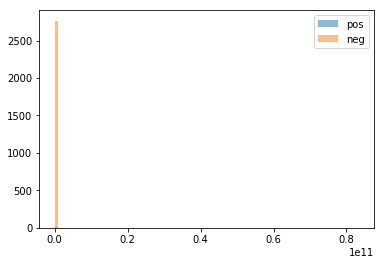

In [131]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [132]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.6817328519855597


In [75]:
dist_matrix = dist_matrix + dist_matrix.transpose()
print dist_matrix

[[0.00000000e+000 4.93595301e+002 0.00000000e+000 ... 5.81601355e-172
  4.17656960e-163 1.69624878e-308]
 [4.93595301e+002 0.00000000e+000 0.00000000e+000 ... 4.57121213e-161
  1.66047308e-152 3.24742988e-295]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.55352044e-082
  5.11304976e-088 2.02158273e-019]
 ...
 [5.81601355e-172 4.57121213e-161 1.55352044e-082 ... 0.00000000e+000
  2.14621988e+002 4.97468585e-020]
 [4.17656960e-163 1.66047308e-152 5.11304976e-088 ... 2.14621988e+002
  0.00000000e+000 4.41784349e-023]
 [1.69624878e-308 3.24742988e-295 2.02158273e-019 ... 4.97468585e-020
  4.41784349e-023 0.00000000e+000]]


In [77]:
adj_matrix = adj_matrix + adj_matrix.transpose()
print adj_matrix

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [93]:
rank = [1,5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.where(adj_matrix == 1)[0]:
        idx = np.argsort(dist_matrix[i])[::-1]
        if 1 in adj_matrix[i, idx][:r]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)

rank 1: 0.700000
rank 5: 1.000000


In [89]:
AP_list = []
for i in np.where(adj_matrix == 1)[0]:
    ap = average_precision_score(y_true=adj_matrix[i], y_score=dist_matrix[i])
    AP_list.append(ap)
print 'mAP: %f' % (np.mean(AP_list))

mAP: 0.816667
